In [3]:
import os
# Name of the Google Drive folder for this homework.
gdrive_root = '/content/drive/MyDrive'

from google.colab import drive
if not os.path.ismount("/content/drive"):
  drive.mount('/content/drive')
if not os.path.isdir(gdrive_root):
  os.makedirs(gdrive_root)

os.listdir('/content/drive')

['.shortcut-targets-by-id', 'Shareddrives', 'MyDrive', '.Trash-0']

# Introduction
  The study by Zhou et al. (2014) introduced the Human Symptoms–Disease Network (HSDN), built from large-scale text mining of PubMed records indexed with MeSH disease and symptom terms. The authors constructed a bipartite network of diseases and symptoms and then projected it into a disease–disease network where links represented similarity in symptom profiles. They demonstrated that diseases with high symptom similarity were also more likely to share common genes and protein–protein interactions (PPIs), bridging the gap between molecular mechanisms and clinical manifestations. Importantly, the network revealed modular structures (e.g., clusters of metabolic, immune, or neurological diseases) and hub diseases with wide symptom overlap. This resource highlighted the potential of symptom data for disease classification, comorbidity analysis, and drug discovery.

## Data Source

The data used to construct the network was obtained from the **Supplementary Information** section of Zhou et al. (2014). Specifically, **Supplementary Data 4**, was used.

- **Supplementary Data 4** contains the curated list of **disease–disease links** that are supported by both:
  1. **Symptom similarity** (significant overlap in symptom profiles), and  
  2. **Molecular evidence** (shared genes or protein–protein interactions).  

- This dataset integrates **phenotypic similarity** and **molecular mechanisms**, producing **133,106 connections among 1,596 diseases** (Zhou et al., 2014).

- In other words, it represents the **backbone of the Human Symptoms–Disease Network (HSDN)**, where disease–disease relationships are robust and validated from both the clinical (symptom-based) and biological (gene/PPI-based) perspectives.


# Project 1


Whereas Zhou et al. focused on establishing and validating the biomedical relevance of the network, our project applies a **graph-theoretical lens** to characterize its **topological structure**. Specifically standard network measures is calculated:

- **Clustering coefficient** – to assess whether diseases form tightly connected families based on shared symptoms.  
- **Characteristic path length and efficiency** – to evaluate how easily diseases are connected across the network.  
- **Centrality and degree distribution** – to identify hub diseases that play key roles in linking distinct modules.  

To contextualize these findings, this project compares the symptom–disease network to **benchmark networks** (e.g., random or small-world graphs), testing whether the observed patterns reflect non-random, small-world, and modular organization.

By focusing on the **graph-theoretical properties** of this curated dataset, our project extends the original work of Zhou et al. and demonstrates how **network science tools** can uncover the organizational principles of human diseases from both clinical and molecular perspectives.


## Methods

### Data Source
The data used to construct the network was obtained from the **Supplementary Information** of Zhou et al. (2014). Specifically, we used **Supplementary Data 4**, which contains 133,106 validated disease–disease connections among 1,596 diseases. Each link is supported by both **symptom similarity** (derived from text-mined PubMed records indexed with MeSH terms) and **molecular evidence** (shared genes or protein–protein interactions). This dataset represents a robust backbone of the Human Symptoms–Disease Network (HSDN).

### Network Construction
We treated each **disease** as a node and each validated disease–disease association as an undirected edge. Edge weights correspond to the reported similarity score in Supplementary Data 4. For certain analyses, weighted edges were converted to **binary connections** using a threshold on similarity values (e.g., keeping only links above a set cutoff) to reduce network density and facilitate graph metric calculations.

### Graph-Theoretical Measures
We analyzed the resulting disease network using the **Brain Connectivity Toolbox (BCT)** and related libraries. The following standard network statistics were computed:

- **Clustering coefficient** – to quantify the extent to which diseases form tightly connected symptom-based clusters.  
- **Characteristic path length** – to measure the typical number of steps required to connect any two diseases in the network.  
- **Efficiency** – to assess how effectively the network integrates information across all nodes.  
- **Centrality measures** (e.g., degree and betweenness centrality) – to identify hub diseases and bridging diseases that connect otherwise distant parts of the network.  
- **Degree distribution** – to examine whether the network is dominated by a few highly connected diseases or is more evenly structured.

### Benchmark Networks
To assess whether the observed topological features were non-random, we compared the disease–disease network to **benchmark networks** of equal size and density. These included **Erdős–Rényi random graphs** and, where appropriate, **Watts–Strogatz small-world models**. The same graph statistics were computed for both the empirical and benchmark networks, enabling direct comparisons of clustering, path length, and efficiency.

### Software and Implementation
All analyses were performed in Python (v3.10) using the **NetworkX**, **bctpy**, and **NumPy/Pandas** libraries. Data preprocessing and figure generation were carried out in Jupyter notebooks. Figures were produced using **Matplotlib** and **Seaborn** to visualize adjacency matrices, degree distributions, and comparisons between empirical and benchmark networks.


In [5]:
# ===============================
# Project 1: Symptom–Disease Network (BCT metrics)
# Requirements: pandas, numpy, networkx, bctpy, matplotlib (optional for plots)
# If needed: !pip install pandas numpy networkx bctpy matplotlib
# ===============================

import pandas as pd
import numpy as np
import networkx as nx
import bct
import matplotlib.pyplot as plt

In [7]:
# ---------- 1) Load the Supplementary Data 4 edge list ----------
# The file should have 3 columns:
#   Col1: MeSH Disease Term (disease A)
#   Col2: MeSH Disease Term (disease B)
#   Col3: symptom similarity score (float)
# Set the path and separator as appropriate (tab- or comma-separated).
PATH = "/content/drive/MyDrive/41467_2014_BFncomms5212_MOESM1046_ESM.txt"    # <--- change to your filename
SEP = "\t"                           # "\t" for TSV; use "," if CSV

df = pd.read_csv(PATH, sep=SEP, header=0)

# Normalize column names to standard names
# Handle cases like duplicate column name "MeSH Disease Term.1"
cols = list(df.columns)
src_col, dst_col, w_col = cols[0], cols[1], cols[2]
df = df.rename(columns={src_col: "disease1", dst_col: "disease2", w_col: "weight"})

# Optionally drop self-loops & NaNs, and ensure numeric weights
df = df.dropna(subset=["disease1", "disease2", "weight"])
df = df[df["disease1"] != df["disease2"]]
df["weight"] = pd.to_numeric(df["weight"], errors="coerce")
df = df.dropna(subset=["weight"])

print(f"Loaded edges: {len(df):,}")
print(df.head(3))

Loaded edges: 133,106
                       disease1                         disease2    weight
0  Histiocytoma, Benign Fibrous                         Aneurysm  0.591937
1  Histiocytoma, Benign Fibrous            Carcinoma, Basal Cell  0.310479
2       Arthropathy, Neurogenic  Corneal Dystrophies, Hereditary  0.133123


In [8]:
# ---------- 2) Build a weighted undirected graph ----------
G_w = nx.from_pandas_edgelist(
    df, source="disease1", target="disease2",
    edge_attr="weight", create_using=nx.Graph()
)

print(f"Nodes: {G_w.number_of_nodes()}, Edges: {G_w.number_of_edges()}")


Nodes: 1596, Edges: 133106


In [9]:
# ---------- 3) Make a binary graph by density threshold ----------
def threshold_by_density_weighted_graph(G_weighted: nx.Graph, keep_density: float = 0.10) -> nx.Graph:
    """Keep the strongest edges up to a target density fraction of all edges."""
    edges = [(u, v, d["weight"]) for u, v, d in G_weighted.edges(data=True)]
    edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)
    m_keep = int(np.floor(keep_density * len(edges_sorted)))
    edges_kept = edges_sorted[:max(m_keep, 1)]  # keep at least 1 edge if tiny graph

    G_bin = nx.Graph()
    G_bin.add_nodes_from(G_weighted.nodes())
    G_bin.add_edges_from([(u, v) for u, v, w in edges_kept])
    return G_bin

KEEP_DENSITY = 0.10   #TODO: can try 0.05 / 0.15 for sensitivity
G_b = threshold_by_density_weighted_graph(G_w, KEEP_DENSITY)

# Work on the Largest Connected Component (LCC) to avoid path-length issues
def largest_cc(G: nx.Graph) -> nx.Graph:
    if G.number_of_nodes() == 0:
        return G
    comp_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(comp_nodes).copy()

G_b_lcc = largest_cc(G_b)
G_w_lcc = largest_cc(G_w)

# ✅ replacement for nx.info
print(f"Binary LCC: {G_b_lcc.number_of_nodes()} nodes, {G_b_lcc.number_of_edges()} edges")


Binary LCC: 1416 nodes, 13305 edges


In [10]:
# ---------- 4) Convert NetworkX graph -> adjacency matrices for BCT ----------
# Keep a fixed node ordering so matrices line up
nodes = list(G_b_lcc.nodes())
idx = {n:i for i,n in enumerate(nodes)}

# Binary adjacency (0/1)
B = np.zeros((len(nodes), len(nodes)), dtype=int)
for u, v in G_b_lcc.edges():
    i, j = idx[u], idx[v]
    B[i, j] = 1
    B[j, i] = 1

# Weighted adjacency (use same node set, fill weights from weighted LCC)
# If a weighted edge isn’t in weighted LCC, treat as 0
W = np.zeros((len(nodes), len(nodes)), dtype=float)
Gw_sub = G_w_lcc.subgraph(nodes).copy()
for u, v, d in Gw_sub.edges(data=True):
    i, j = idx[u], idx[v]
    W[i, j] = float(d.get("weight", 0.0))
    W[j, i] = float(d.get("weight", 0.0))

In [11]:
# ---------- 5) Compute required metrics on the empirical network ----------

# (1) Clustering coefficient
C_bin = bct.clustering_coef_bu(B).mean()     # binary clustering (mean over nodes)
C_w   = bct.clustering_coef_wu(W).mean()     # weighted (Onnela) clustering (mean)

# (2) Path-length (characteristic path length; binary)
# distance_bin(B) returns (D, Bshort); charpath takes (D) or (distance_bin(B))
L_bin = bct.charpath(bct.distance_bin(B))[0]  # [0] = characteristic path length

# (3) Centrality measure(s)
deg_vec = bct.degrees_und(B)                  # degree per node (binary)
bet_vec = bct.betweenness_bin(B)              # betweenness centrality (binary)
# Optional: degree centrality as fraction of (n-1)
deg_cent = deg_vec / (B.shape[0] - 1)

# (4) Efficiency measure(s)
Eglob_bin = bct.efficiency_bin(B, local=False)  # global efficiency (binary)
Eloc_bin  = bct.efficiency_bin(B, local=True)   # local efficiency per node (binary)
Eloc_mean = np.mean(Eloc_bin)

# (5) Degree distribution (report vector + summary)
deg_mean  = float(np.mean(deg_vec))
deg_std   = float(np.std(deg_vec))
deg_min   = int(np.min(deg_vec))
deg_max   = int(np.max(deg_vec))

print("\n=== Empirical network (binary LCC) ===")
print(f"Nodes: {B.shape[0]}  Edges: {int(B.sum()/2)}  "
      f"Density: {B.sum()/(B.shape[0]*(B.shape[0]-1)):.3f}")
print(f"Clustering (binary mean): {C_bin:.3f}   Clustering (weighted mean, Onnela): {C_w:.3f}")
print(f"Characteristic path length (binary): {L_bin:.3f}")
print(f"Global efficiency (binary): {Eglob_bin:.3f}   Local efficiency (binary, mean): {Eloc_mean:.3f}")
print(f"Degree (mean±sd, min–max): {deg_mean:.2f}±{deg_std:.2f}, {deg_min}–{deg_max}")

# Identify top hub / bridge diseases for your Results text
top_k = 10
node_arr = np.array(nodes)

top_deg_idx = np.argsort(-deg_vec)[:top_k]
top_bet_idx = np.argsort(-bet_vec)[:top_k]

print("\nTop-degree diseases:")
for i in top_deg_idx:
    print(f"{node_arr[i]}   degree={int(deg_vec[i])}")

print("\nTop-betweenness diseases:")
for i in top_bet_idx:
    print(f"{node_arr[i]}   betweenness={bet_vec[i]:.4f}")



=== Empirical network (binary LCC) ===
Nodes: 1416  Edges: 13305  Density: 0.013
Clustering (binary mean): 0.500   Clustering (weighted mean, Onnela): 0.152
Characteristic path length (binary): 3.828
Global efficiency (binary): 0.291   Local efficiency (binary, mean): 0.638
Degree (mean±sd, min–max): 18.79±21.65, 1–146

Top-degree diseases:
Bone Diseases, Developmental   degree=146
Craniofacial Abnormalities   degree=143
Mental Retardation   degree=134
Growth Disorders   degree=129
Hand Deformities, Congenital   degree=125
Metabolism, Inborn Errors   degree=123
Foot Deformities, Congenital   degree=121
Microcephaly   degree=119
Abnormalities, Multiple   degree=118
Ectodermal Dysplasia   degree=118

Top-betweenness diseases:
Kidney Neoplasms   betweenness=61289.2233
Skin Neoplasms   betweenness=61024.7683
Growth Disorders   betweenness=59259.2836
Brain Diseases   betweenness=51331.7992
Bone Diseases   betweenness=48122.4878
Bone Diseases, Developmental   betweenness=47834.3544
Melanoma

In [12]:
# ---------- helper for BCT metrics ----------
def bct_quick_stats(Bmat: np.ndarray):
    """Return clustering, characteristic path length, global efficiency for a binary adjacency matrix."""
    C = bct.clustering_coef_bu(Bmat).mean()
    L = bct.charpath(bct.distance_bin(Bmat))[0]
    E = bct.efficiency_bin(Bmat, local=False)
    return C, L, E

# ---------- 6) Build benchmark graphs with matched size/density ----------
n = B.shape[0]
m = int(B.sum() // 2)
avg_k = max(2, int(round(2 * m / n)))  # average degree >= 2

def even_k_close_to(target_k, n):
    k = max(2, (target_k // 2) * 2)
    if k >= n:
        k = (n - 2) if (n - 2) % 2 == 0 else (n - 3)
    return k

k_ws = even_k_close_to(avg_k, n)

def to_BCT_adj(G):
    """Convert NetworkX graph to numpy (0/1) adjacency for BCT; use LCC to avoid path issues."""
    Gc = largest_cc(G)
    return nx.to_numpy_array(Gc, dtype=int)

# (i) Random (Erdős–Rényi) with same (n, m)
G_er = nx.gnm_random_graph(n, m, seed=42)
B_er = to_BCT_adj(G_er)
C_er, L_er, E_er = bct_quick_stats(B_er)

# (ii) Regular lattice (Watts–Strogatz with beta=0 → ring lattice)
G_reg = nx.watts_strogatz_graph(n, k_ws, 0.0, seed=42)
B_reg = to_BCT_adj(G_reg)
C_reg, L_reg, E_reg = bct_quick_stats(B_reg)

# (iii) Small-world modular (simplified caveman + rewiring)
def caveman_smallworld(n, n_comms=8, p_rewire=0.03, seed=42):
    rng = np.random.default_rng(seed)
    sizes = [n // n_comms] * n_comms
    for i in range(n % n_comms):
        sizes[i] += 1
    G = nx.connected_caveman_graph(n_comms, sizes[0])  # equal-size comms
    # rewire some edges randomly
    edges = list(G.edges())
    for (u, v) in edges:
        if rng.random() < p_rewire:
            G.remove_edge(u, v)
            w = rng.integers(0, n)
            while w == u or G.has_edge(u, w):
                w = rng.integers(0, n)
            G.add_edge(u, w)
    return G

G_swmod = caveman_smallworld(n, n_comms=min(12, max(4, n // 150)), p_rewire=0.03, seed=42)
B_swmod = to_BCT_adj(G_swmod)
C_swmod, L_swmod, E_swmod = bct_quick_stats(B_swmod)

# --- Empirical stats already computed in Part 5 ---
C_emp, L_emp, E_emp = C_bin, L_bin, Eglob_bin

print("\n=== Benchmarks (binary) ===")
print(f"Empirical:        C={C_emp:.3f}  L={L_emp:.3f}  E={E_emp:.3f}")
print(f"Random (ER):      C={C_er:.3f}  L={L_er:.3f}  E={E_er:.3f}")
print(f"Regular lattice:  C={C_reg:.3f} L={L_reg:.3f} E={E_reg:.3f}")
print(f"SW modular:       C={C_swmod:.3f} L={L_swmod:.3f} E={E_swmod:.3f}")

sigma = (C_emp / C_er) / (L_emp / L_er)
print(f"\nSmall-world index σ (vs ER): {sigma:.3f}")



=== Benchmarks (binary) ===
Empirical:        C=0.500  L=3.828  E=0.291
Random (ER):      C=0.014  L=2.775  E=0.377
Regular lattice:  C=0.706 L=39.807 E=0.063
SW modular:       C=0.913 L=2.180 E=0.507

Small-world index σ (vs ER): 25.756


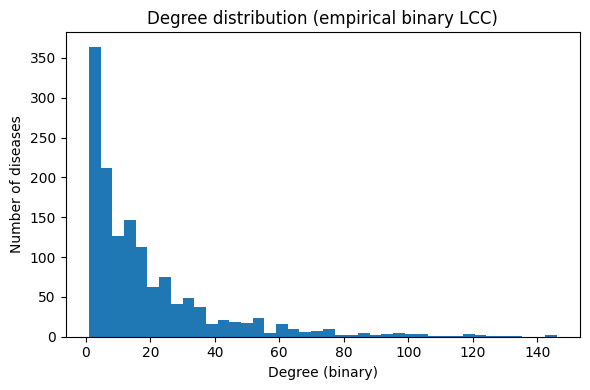

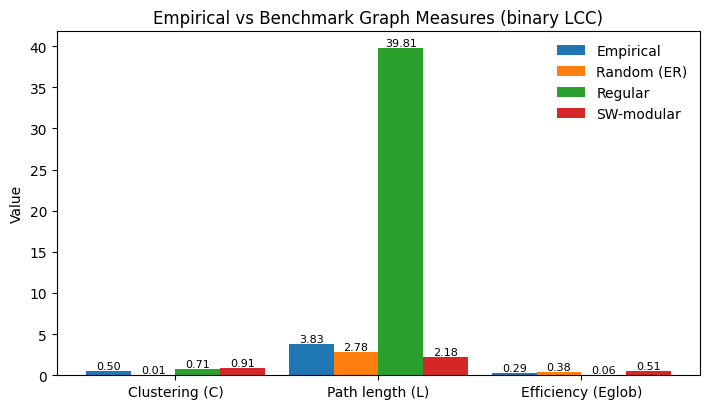

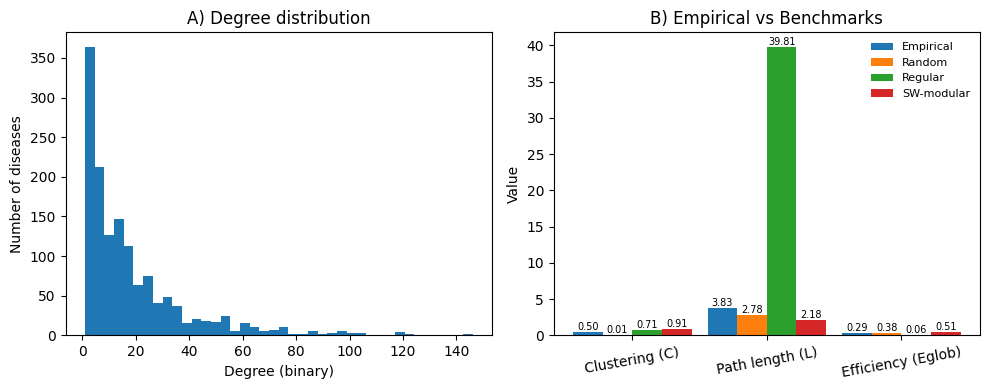

In [16]:
# ---------- Safety: get degree vector if not already defined ----------
if "deg_vec" not in globals():
    # degree from binary adjacency (B) of your empirical LCC
    deg_vec = B.sum(axis=0)

# ---------- Panel A: Degree histogram ----------
plt.figure(figsize=(6,4))
plt.hist(deg_vec, bins=40)
plt.xlabel("Degree (binary)")
plt.ylabel("Number of diseases")
plt.title("Degree distribution (empirical binary LCC)")
plt.tight_layout()
plt.savefig("figA_degree_hist.pdf", dpi=300)
plt.show()

# ---------- Panel B: Metrics bar chart (Empirical vs Benchmarks) ----------
labels = ["Clustering (C)", "Path length (L)", "Efficiency (Eglob)"]
emp = [C_emp, L_emp, E_emp]
rnd = [C_er,  L_er,  E_er]
reg = [C_reg, L_reg, E_reg]
swm = [C_swmod, L_swmod, E_swmod]

x = np.arange(len(labels))
w = 0.22

plt.figure(figsize=(7.2,4.2))
bars_emp = plt.bar(x - 1.5*w, emp, width=w, label="Empirical")
bars_rnd = plt.bar(x - 0.5*w, rnd, width=w, label="Random (ER)")
bars_reg = plt.bar(x + 0.5*w, reg, width=w, label="Regular")
bars_swm = plt.bar(x + 1.5*w, swm, width=w, label="SW-modular")

plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Empirical vs Benchmark Graph Measures (binary LCC)")
plt.legend(frameon=False)

# annotate bars with values
def annotate(bars):
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}",
                 ha="center", va="bottom", fontsize=8)
annotate(bars_emp); annotate(bars_rnd); annotate(bars_reg); annotate(bars_swm)

plt.tight_layout()
plt.savefig("figB_metrics_bar.pdf", dpi=300)
plt.show()

# ---------- Combined multi-panel (A+B in one figure) ----------
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# A) degree histogram
axes[0].hist(deg_vec, bins=40)
axes[0].set_xlabel("Degree (binary)")
axes[0].set_ylabel("Number of diseases")
axes[0].set_title("A) Degree distribution")

# B) bar chart
bars_emp = axes[1].bar(x - 1.5*w, emp, width=w, label="Empirical")
bars_rnd = axes[1].bar(x - 0.5*w, rnd, width=w, label="Random")
bars_reg = axes[1].bar(x + 0.5*w, reg, width=w, label="Regular")
bars_swm = axes[1].bar(x + 1.5*w, swm, width=w, label="SW-modular")
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=10)
axes[1].set_ylabel("Value")
axes[1].set_title("B) Empirical vs Benchmarks")
axes[1].legend(frameon=False, fontsize=8)

# annotate bars
for bars in (bars_emp, bars_rnd, bars_reg, bars_swm):
    for b in bars:
        h = b.get_height()
        axes[1].text(b.get_x() + b.get_width()/2, h, f"{h:.2f}",
                     ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.savefig("fig_results_AB.pdf", dpi=600)
plt.show()

k-core (k=12): 526 nodes, 8720 edges


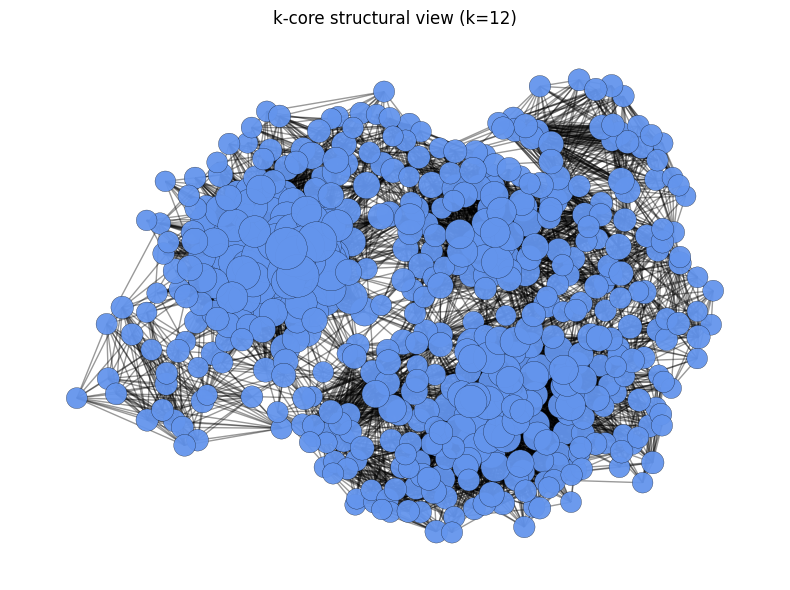

In [14]:
# Build a graph from B (empirical binary LCC)
G_plot = nx.from_numpy_array(B)
# keep a moderate k-core
k = 12  # try 10–15 until node count ~100–300
Core = nx.k_core(G_plot, k=k)
print(f"k-core (k={k}): {Core.number_of_nodes()} nodes, {Core.number_of_edges()} edges")

pos = nx.kamada_kawai_layout(Core)
sizes = [150 + 6*Core.degree(n) for n in Core.nodes()]
plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(Core, pos, node_size=sizes, node_color="cornflowerblue",
                       edgecolors="black", linewidths=0.2, alpha=0.95)
nx.draw_networkx_edges(Core, pos, alpha=0.4)
plt.title(f"k-core structural view (k={k})")
plt.axis("off")
plt.tight_layout()
plt.savefig("figC_kcore.png", dpi=600)
plt.show()


/tmp/ipython-input-3884345105.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', max(3, len(communities)))


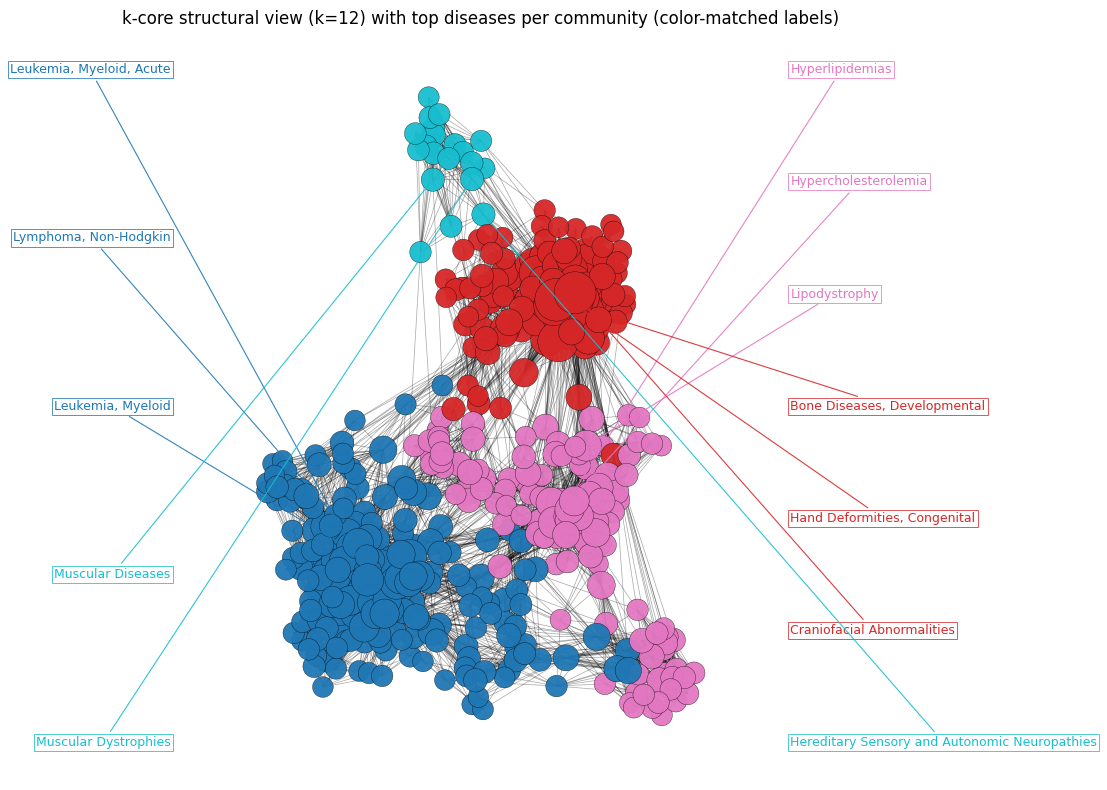

Top 3 diseases in each community (name, degree):
Community 0: Lymphoma, Non-Hodgkin (deg=82); Leukemia, Myeloid, Acute (deg=74); Leukemia, Myeloid (deg=73)
Community 1: Bone Diseases, Developmental (deg=133); Craniofacial Abnormalities (deg=127); Hand Deformities, Congenital (deg=121)
Community 2: Hyperlipidemias (deg=64); Hypercholesterolemia (deg=63); Lipodystrophy (deg=58)
Community 3: Hereditary Sensory and Autonomic Neuropathies (deg=22); Muscular Diseases (deg=22); Muscular Dystrophies (deg=22)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# --- communities on the k-core ---
communities = list(greedy_modularity_communities(Core))
comm_id = {n: cid for cid, com in enumerate(communities) for n in com}

# --- top-3 by degree per community ---
deg_core = dict(Core.degree())
labels_top = {}
top3_by_comm = []
for cid, com in enumerate(communities):
    top3 = sorted(com, key=lambda n: deg_core[n], reverse=True)[:3]
    top3_by_comm.append((cid, [(nodes[n], deg_core[n]) for n in top3]))
    for n in top3:
        labels_top[n] = nodes[n]

# --- layout, colors, sizes ---
pos = nx.spring_layout(Core, seed=42)
cmap = cm.get_cmap('tab10', max(3, len(communities)))
node_colors = [comm_id[n] for n in Core.nodes()]
sizes = [150 + 6*deg_core[n] for n in Core.nodes()]

# --- draw graph ---
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(Core, pos, node_size=sizes, node_color=node_colors,
                       cmap=cmap, edgecolors="black", linewidths=0.25, alpha=0.95)
nx.draw_networkx_edges(Core, pos, alpha=0.35, width=0.5)

# --- side columns (no overlap) ---
xlim = plt.xlim(); ylim = plt.ylim()
mid_x = (xlim[0] + xlim[1]) / 2
left_items  = [(n, labels_top[n], pos[n][1]) for n in labels_top if pos[n][0] <  mid_x]
right_items = [(n, labels_top[n], pos[n][1]) for n in labels_top if pos[n][0] >= mid_x]
left_items.sort(key=lambda t: t[2]); right_items.sort(key=lambda t: t[2])

yl = np.linspace(0.95, 0.05, max(1, len(left_items)))
yr = np.linspace(0.95, 0.05, max(1, len(right_items)))
def ynorm_to_data(y_norm): return ylim[0] + y_norm * (ylim[1] - ylim[0])
x_left  = xlim[0] - 0.10*(xlim[1] - xlim[0])
x_right = xlim[1] + 0.10*(xlim[1] - xlim[0])

def place_column(items, yvals, x_text, ha):
    for ((n, label, _), y_norm) in zip(items, yvals):
        y_text = ynorm_to_data(y_norm)
        x_node, y_node = pos[n]
        color = cmap(comm_id[n] % cmap.N)   # <-- color by the node's community
        plt.annotate(
            label, (x_node, y_node), xytext=(x_text, y_text), textcoords="data",
            ha=ha, va="center", fontsize=9, color=color,
            bbox=dict(facecolor="white", alpha=0.9, edgecolor=color, linewidth=0.6, pad=1.5),
            arrowprops=dict(arrowstyle="-", color=color, lw=0.8, alpha=0.9)
        )

place_column(left_items,  yl, x_left,  ha="right")
place_column(right_items, yr, x_right, ha="left")

plt.title(f"k-core structural view (k={k}) with top diseases per community (color-matched labels)")
plt.axis("off")
plt.tight_layout()
plt.savefig("figC_kcore_top3_per_cluster_colormatch.pdf", dpi=1200)
plt.show()

# (optional) print list for Results
print("Top 3 diseases in each community (name, degree):")
for cid, trio in top3_by_comm:
    print(f"Community {cid}: " + "; ".join([f"{name} (deg={d})" for name, d in trio]))
